## Some Package Import and Data Preparation

In [16]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from numpy import *
from sklearn import *
from copy import deepcopy

xl = pd.ExcelFile('data2.xlsx')
xl.sheet_names # we'll take 7th
dfs = {sheet: xl.parse(sheet) for sheet in xl.sheet_names}
data1 = dfs['7']
data2 = dfs['1'].loc[:,['Patient','Age at Diagnosis']].drop([554]).drop_duplicates()
data3 = pd.read_csv('data1.csv')
combined_data = data1.set_index('Patient').join(data2.set_index('Patient')).join(data3.set_index('Patient'))
combined_data['label'] = (combined_data['Patient Type'] == 'Healthy').astype(int)
combined_data = combined_data.drop(['Patient Type'],axis=1)
print('The number of samples and features are %d and %d, respectively'%(combined_data.shape[0],combined_data.shape[1]))

x = combined_data.iloc[:, 0:44]

y=combined_data.iloc[:,44]

The number of samples and features are 423 and 45, respectively


## Part 1. Missing Value

Let's have a look about the missing values in the dataset.

In [2]:
print('An Overview About Missing Value')
print(x.isnull().sum())

An Overview About Missing Value
Median cfDNA Fragment Size (bp)               0
GC Corrected Fragment Ratio Profile*          0
Age at Diagnosis                             15
PA Score                                      0
% of Mapped Reads Mapping to Mitochondria     0
Z Score (chr1p)                               0
Z Score (chr1q)                               0
Z Score (chr2p)                               0
Z Score (chr2q)                               0
Z Score (chr3p)                               0
Z Score (chr3q)                               0
Z Score (chr4p)                               0
Z Score (chr4q)                               0
Z Score (chr5p)                               0
Z Score (chr5q)                               0
Z Score (chr6p)                               0
Z Score (chr6q)                               0
Z Score (chr7p)                               0
Z Score (chr7q)                               0
Z Score (chr8p)                               0
Z Score 

In [11]:
print('The specific sample with missing value')
print(x[x.isnull().values==True])

The specific sample with missing value
           Median cfDNA Fragment Size (bp)  \
Patient                                      
CGCRC333                               163   
CGCRC336                               162   
CGCRC338                               162   
CGCRC341                               164   
CGCRC342                               158   
CGPLBR12                               164   
CGPLBR18                               163   
CGPLBR32                               166   
CGPLBR84                               169   
CGPLPA114                              166   
CGPLPA115                              165   
CGPLPA117                              165   
CGPLPA137                              166   
CGPLPA139                              166   
CGPLPA155                              165   

           GC Corrected Fragment Ratio Profile*  Age at Diagnosis   PA Score  \
Patient                                                                        
CGCRC333          

- #### Delete samples with missing values.

In [93]:
'''
axis: stands for deleting a whole row or a whole column. By default axis = 0, that is, deleting a row.

how: defaults to 'any', which removes rows/columns which have values with any NaN. 
    In addition, when how = 'all', it will delete rows/columns which have valus with all NaN.

inplace: False(default)--return new dataset, True--Operates on the original dataset
'''
x_new = x.dropna(axis=0, how ='any', inplace=False)  

# print(x_new .isnull().sum())

- #### Fill in with the mean.

In [44]:
age_mean = mean(x['Age at Diagnosis'])
x_new = copy.deepcopy(x)
x_new[isnan(x_new)]= age_mean
# print(x_new .isnull().sum())

- #### Fill in with the mode.

In [43]:
from scipy import stats 
age_mode = stats.mode(x['Age at Diagnosis'])[0][0]
x_new = copy.deepcopy(x)
x_new[isnan(x_new)]= age_mode
# print(x_new .isnull().sum())

- #### Fill in with the random.

In [38]:
x_new = copy.deepcopy(x)
r = where(np.isnan(x_new))[0] # Obtain the row index of NaN
c = where(np.isnan(x_new))[1] # Obtain the column index of NaN

for i in range(len(r)):
    x_new.iloc[r[i],c[i]] = random.randint(min(x['Age at Diagnosis']), max(x['Age at Diagnosis']))
# print(x_new .isnull().sum())

- #### Fill in with model based--Logistic Regression.

In [63]:
x_new = copy.deepcopy(x)
##---   Prepare the dataset   ---##
data_train = x.dropna(axis=0, how ='any', inplace=False)
y_train = data_train['Age at Diagnosis']
x_train = data_train.drop(['Age at Diagnosis'], axis = 1)

##---   Build the model   ---##
model = linear_model.LogisticRegression(random_state=920).fit(x_train, y_train)

##---   Predict on the NaN   ---##
r = where(np.isnan(x_new))[0] # Obtain the row index of NaN
c = where(np.isnan(x_new))[1] # Obtain the column index of NaN
for i in range(len(r)):
    x_new.iloc[r[i],c[i]] = model.predict([x_new.iloc[r[i],:].drop(['Age at Diagnosis'])])

# print(x_new .isnull().sum())

## Part 2. Normalization

- #### Z-Score standardization

In [88]:
x_new = deepcopy(x)
age_mean = mean(x['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean
scaler = preprocessing.StandardScaler().fit(x_new)
x_scaled = pd.DataFrame(scaler.transform(x_new), columns = x_new.columns)
x_scaled

,Median cfDNA Fragment Size (bp),GC Corrected Fragment Ratio Profile*,Age at Diagnosis,PA Score,% of Mapped Reads Mapping to Mitochondria,Z Score (chr1p),Z Score (chr1q),Z Score (chr2p),Z Score (chr2q),Z Score (chr3p),...,Z Score (chr17p),Z Score (chr17q),Z Score (chr18p),Z Score (chr18q),Z Score (chr19p),Z Score (chr19q),Z Score (chr20p),Z Score (chr20q),Z Score (chr21q),Z Score (chr22q)
0,-1.807474,-4.620349,0.957636,5.498992,-0.184907,-6.891929,-8.596791,6.282144,5.571978,-11.542196,...,-1.284605,-3.245129,-2.378899,-2.632208,-0.305345,-5.439839,3.624706,1.505903,-2.805366,-2.153452
1,-0.364905,-0.196176,-0.795324,-0.047027,-0.346829,-0.359471,-1.037782,-0.515498,-0.391772,-0.077298,...,0.237430,0.041679,0.202464,-0.079668,1.683452,1.056592,-0.051570,-0.116298,0.024668,0.280104
2,-0.364905,0.263598,-0.405778,1.136679,0.015383,1.967300,2.318702,1.227022,1.103389,0.954008,...,-0.093084,0.126841,-0.343269,-0.265908,-0.584391,-0.989085,-0.204408,-0.140039,-0.387181,0.023536
3,-0.364905,-0.110652,0.762862,0.350454,-0.409643,-0.385164,-0.993551,-0.369068,-0.325023,-0.233947,...,0.301872,0.220182,0.324207,0.007547,2.127701,1.293305,-0.273034,-0.097551,0.449873,0.666201
4,-0.364905,-0.370529,1.639342,0.018740,-0.272260,-0.578270,-1.010980,-0.193819,-0.228938,0.080665,...,0.188998,-0.165029,0.117184,0.189295,0.515525,0.769871,0.106505,-0.061130,0.381159,0.286957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,1.077664,0.125200,-0.113618,0.242311,-0.024367,-0.141279,0.048770,-0.315351,-0.199561,-0.312304,...,0.394220,0.374490,0.282397,0.133160,0.845930,0.048424,-0.465401,-0.166696,0.242498,0.365429
419,1.558520,-0.174034,0.957636,0.646375,1.906982,0.148502,0.097544,-0.666945,0.053420,-0.261958,...,0.211222,0.033676,0.577410,0.025847,0.409240,-0.406938,-0.612093,-0.220013,0.439519,0.148283
420,1.558520,-0.865876,1.055022,0.849447,0.851021,-0.792368,-0.562547,-0.294549,0.548575,0.150079,...,-0.124425,-0.716763,0.645652,0.284950,0.073461,-1.135357,-0.357487,-0.307280,0.123239,-0.084247
421,0.596808,-0.182292,-0.113618,0.704061,-0.180422,0.149839,0.245680,0.126978,-0.294469,-0.100305,...,0.126293,0.453460,0.337979,-0.012687,-0.380951,-0.725592,-0.058379,0.015837,0.223377,0.421840


- #### Max-Min  normalization

In [87]:
x_new = deepcopy(x)
age_mean = mean(x['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean
scaler = preprocessing.MinMaxScaler().fit(x_new)
x_scaled = pd.DataFrame(scaler.transform(x_new), columns = x_new.columns)
x_scaled

,Median cfDNA Fragment Size (bp),GC Corrected Fragment Ratio Profile*,Age at Diagnosis,PA Score,% of Mapped Reads Mapping to Mitochondria,Z Score (chr1p),Z Score (chr1q),Z Score (chr2p),Z Score (chr2q),Z Score (chr3p),...,Z Score (chr17p),Z Score (chr17q),Z Score (chr18p),Z Score (chr18q),Z Score (chr19p),Z Score (chr19q),Z Score (chr20p),Z Score (chr20q),Z Score (chr21q),Z Score (chr22q)
0,0.411765,0.439092,0.763889,0.846646,0.033445,0.085819,0.000000,0.785664,0.627770,0.050988,...,0.734726,0.352209,0.562092,0.755801,0.488448,0.181512,0.640261,0.174673,0.470940,0.786019
1,0.588235,0.896735,0.513889,0.072202,0.016395,0.549178,0.434682,0.344316,0.299643,0.795558,...,0.836006,0.485485,0.706842,0.944279,0.613075,0.600878,0.462703,0.041226,0.656264,0.952322
2,0.588235,0.944295,0.569444,0.237494,0.054534,0.714220,0.627697,0.457452,0.381907,0.862535,...,0.814013,0.488938,0.676240,0.930527,0.470962,0.468823,0.455321,0.039273,0.629294,0.934789
3,0.588235,0.905582,0.736111,0.127706,0.009781,0.547355,0.437226,0.353823,0.303316,0.785385,...,0.840294,0.492723,0.713669,0.950719,0.640913,0.616159,0.452007,0.042768,0.684109,0.978707
4,0.588235,0.878700,0.861111,0.081385,0.024247,0.533658,0.436223,0.365201,0.308602,0.805817,...,0.832783,0.477103,0.702060,0.964139,0.539887,0.582369,0.470338,0.045764,0.679609,0.952790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,0.764706,0.929979,0.611111,0.112605,0.050349,0.564655,0.497165,0.357310,0.310219,0.780296,...,0.846439,0.498980,0.711324,0.959994,0.560592,0.535798,0.442716,0.037080,0.670529,0.958153
419,0.823529,0.899026,0.763889,0.169028,0.253709,0.585209,0.499969,0.334483,0.324138,0.783565,...,0.834262,0.485161,0.727867,0.952070,0.533227,0.506403,0.435631,0.032694,0.683431,0.943313
420,0.823529,0.827461,0.777778,0.197385,0.142522,0.518472,0.462011,0.358661,0.351381,0.810325,...,0.811927,0.454731,0.731694,0.971202,0.512185,0.459381,0.447928,0.025515,0.662719,0.927423
421,0.705882,0.898171,0.611111,0.177083,0.033917,0.585304,0.508488,0.386029,0.304997,0.794064,...,0.828611,0.502182,0.714441,0.949225,0.483710,0.485832,0.462374,0.052096,0.669276,0.962008


- #### Decimal  scaling

In [83]:
def Dec_scale(x):
    for i in x:
        p = x[i].max()
        q = ceil(log10(abs(p)))
        x[i] = x[i]/10**q 
        
x_new = deepcopy(x)
age_mean = mean(x_new['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean
Dec_scale(x_new)
x_new

,Median cfDNA Fragment Size (bp),GC Corrected Fragment Ratio Profile*,Age at Diagnosis,PA Score,% of Mapped Reads Mapping to Mitochondria,Z Score (chr1p),Z Score (chr1q),Z Score (chr2p),Z Score (chr2q),Z Score (chr3p),...,Z Score (chr17p),Z Score (chr17q),Z Score (chr18p),Z Score (chr18q),Z Score (chr19p),Z Score (chr19q),Z Score (chr20p),Z Score (chr20q),Z Score (chr21q),Z Score (chr22q)
Patient,,,,,,,,,,,,,,,,,,,,,
CGCRC291,0.163,0.526793,0.69,0.237431,0.004841,-0.202719,-0.181854,0.250863,0.262012,-1.029680,...,-0.113782,-0.163038,-0.252222,-2.726629,-0.053637,-0.078879,0.260733,0.025466,-0.087198,-1.160398
CGCRC292,0.166,0.883525,0.51,0.020251,0.002704,-0.013604,-0.016890,-0.014159,-0.013529,-0.023099,...,0.009188,-0.007271,0.020636,-0.202204,0.184786,0.015419,-0.000016,-0.000207,-0.004176,0.062969
CGCRC293,0.166,0.920598,0.55,0.066605,0.007485,0.053757,0.056360,0.053778,0.055551,0.067446,...,-0.017516,-0.003235,-0.037049,-0.386393,-0.087090,-0.014275,-0.010856,-0.000583,-0.016258,-0.066009
CGCRC294,0.166,0.890421,0.67,0.035816,0.001875,-0.014347,-0.015925,-0.008450,-0.010445,-0.036852,...,0.014394,0.001188,0.033505,-0.115950,0.238044,0.018855,-0.015724,0.000089,0.008298,0.257064
CGCRC296,0.166,0.869467,0.76,0.022826,0.003688,-0.019938,-0.016305,-0.001617,-0.006006,-0.009230,...,0.005275,-0.017067,0.011622,0.063797,0.044771,0.011257,0.011196,0.000666,0.006282,0.066415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGST58,0.169,0.909439,0.58,0.031581,0.006960,-0.007287,0.006822,-0.006355,-0.004649,-0.043732,...,0.021855,0.008501,0.029086,0.008279,0.084381,0.000785,-0.029368,-0.001005,0.002214,0.105863
CGST67,0.170,0.885311,0.69,0.047404,0.032451,0.001102,0.007887,-0.020063,0.007040,-0.039311,...,0.007070,-0.007650,0.060270,-0.097851,0.032030,-0.005825,-0.039772,-0.001849,0.007994,-0.003298
CGST77,0.170,0.829526,0.70,0.055357,0.018514,-0.026136,-0.006519,-0.005544,0.029917,-0.003136,...,-0.020048,-0.043215,0.067483,0.158397,-0.008225,-0.016398,-0.021714,-0.003230,-0.001284,-0.120193


## Part 3. Dimension Reduction

- #### Pathway 1: Feature extraction

After feature extraction, the size of feature is: (423, 2)


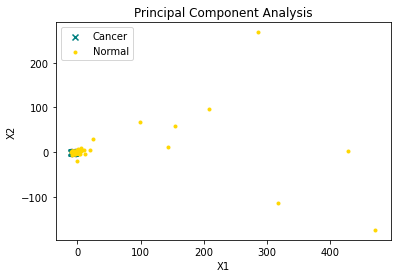

In [94]:
# ----------------------------------------------------------#   
#   Feature extraction with Principal Component Analysis   #
#---------------------------------------------------------# 

##---   Fill in the missing value with zero   ---##
x_new = deepcopy(x)
x_new[isnan(x_new)]= 0

##---   Principal Component Analysis   ---##
x_extracted=decomposition.PCA(n_components=2).fit_transform(x_new)
print('After feature extraction, the size of feature is:', x_extracted.shape)

##---   Dataset Visualization after feature extraction   ---##
plt.plot()
type1_x1 = []
type1_x2 = []
type2_x1 = []
type2_x2 = []
# Separate the dataset by different classes
for i in range(len(y)):
    if y[i] == 1:  # Cancer
        type1_x1.append(x_extracted[i][0])
        type1_x2.append(x_extracted[i][1])

    if y[i] == 0:  # Normal
        type2_x1.append(x_extracted[i][0])
        type2_x2.append(x_extracted[i][1])
type1 = plt.scatter(type1_x1, type1_x2, c='teal', marker='x')
type2 = plt.scatter(type2_x1, type2_x2, c='gold', marker='.')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Principal Component Analysis')
plt.legend((type1, type2), (u'Cancer', u'Normal'), loc=2)
plt.show()

After feature extraction, the size of feature is: (423, 1)


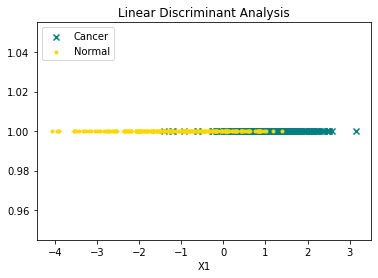

In [95]:
# ----------------------------------------------------------#   
#   Feature extraction with Linear Discriminant Analysis   #
#---------------------------------------------------------# 


##---   Fill in the missing value with zero   ---##
x_new = deepcopy(x)
x_new[isnan(x_new)]= 0

##---   Linear Discriminant Analysis   ---##
x_extracted=discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(x_new,y)
print('After feature extraction, the size of feature is:', x_extracted.shape)

##---   Dataset Visualization after feature extraction   ---##
plt.plot()
type1_x1 = []
type1_x2 = []
type2_x1 = []
type2_x2 = []
# Separate the dataset by different classes
for i in range(len(y)):
    if y[i] == 1:  # Cancer
        type1_x1.append(x_extracted[i][0])

    if y[i] == 0:  # Normal
        type2_x1.append(x_extracted[i][0])
type1_y = ones([len(type1_x1),1])# As the size of feature after LDA is min(n_classes - 1, n_features), for binary classification, we need to add y to plot.
type2_y = ones([len(type2_x1),1])
type1 = plt.scatter(type1_x1,type1_y, c='teal', marker='x')
type2 = plt.scatter(type2_x1,type2_y, c='gold', marker='.')
plt.xlabel('X1')
plt.title('Linear Discriminant Analysis')
plt.legend((type1, type2), (u'Cancer', u'Normal'), loc=2)
plt.show()

After feature extraction, the size of feature is: (423, 2)


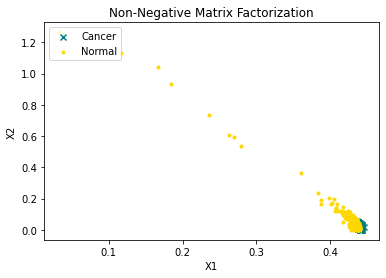

In [96]:
# ---------------------------------------------------------------#   
#   Feature extraction with Non-Negative Matrix Factorization   #
#--------------------------------------------------------------# 

##---   Max-Min normalization to prevent negtive values   ---##
x_new = deepcopy(x)
age_mean = mean(x['Age at Diagnosis'])
x_new[isnan(x_new)] = age_mean
scaler = preprocessing.MinMaxScaler().fit(x_new)
x_scaled = scaler.transform(x_new)

##---   Non-Negative Matrix Factorization   ---##
x_extracted = decomposition.NMF(n_components=2).fit_transform(x_scaled)
print('After feature extraction, the size of feature is:', x_extracted.shape)

##---   Dataset Visualization after feature extraction   ---##
plt.plot()
type1_x1 = []
type1_x2 = []
type2_x1 = []
type2_x2 = []
# Separate the dataset by different classes
for i in range(len(y)):
    if y[i] == 1:  # Cancer
        type1_x1.append(x_extracted[i][0])
        type1_x2.append(x_extracted[i][1])

    if y[i] == 0:  # Normal
        type2_x1.append(x_extracted[i][0])
        type2_x2.append(x_extracted[i][1])
type1 = plt.scatter(type1_x1, type1_x2, c='teal', marker='x')
type2 = plt.scatter(type2_x1, type2_x2, c='gold', marker='.')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Non-Negative Matrix Factorization')
plt.legend((type1, type2), (u'Cancer', u'Normal'), loc=2)
plt.show()

After feature extraction, the size of feature is: (423, 2)


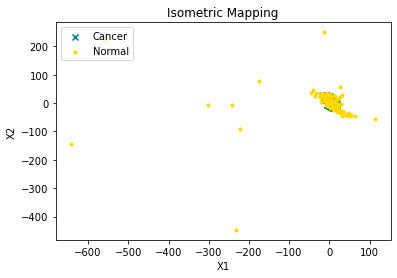

In [97]:
# -----------------------------------------------#   
#   Feature extraction with Isometric Mapping   #
#----------------------------------------------# 

##---   Fill in the missing value with zero   ---##
x_new = deepcopy(x)
x_new[isnan(x_new)]= 0

##---   Isometric Mapping   ---##
x_extracted = manifold.Isomap(n_components=2).fit_transform(x_new)
print('After feature extraction, the size of feature is:', x_extracted.shape)

##---   Dataset Visualization after feature extraction   ---##
plt.plot()
type1_x1 = []
type1_x2 = []
type2_x1 = []
type2_x2 = []
# Separate the dataset by different classes
for i in range(len(y)):
    if y[i] == 1:  # Cancer
        type1_x1.append(x_extracted[i][0])
        type1_x2.append(x_extracted[i][1])

    if y[i] == 0:  # Normal
        type2_x1.append(x_extracted[i][0])
        type2_x2.append(x_extracted[i][1])
type1 = plt.scatter(type1_x1, type1_x2, c='teal', marker='x')
type2 = plt.scatter(type2_x1, type2_x2, c='gold', marker='.')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Isometric Mapping')
plt.legend((type1, type2), (u'Cancer', u'Normal'), loc=2)
plt.show()

After feature extraction, the size of feature is: 2


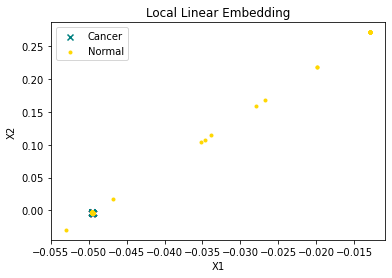

In [98]:
# ----------------------------------------------------#   
#   Feature extraction with Local Linear Embedding   #
#---------------------------------------------------# 

##---   Fill in the missing value with zero   ---##
x_new = deepcopy(x)
x_new[isnan(x_new)]= 0

##---    Local Linear Embedding   ---##
x_extracted = manifold.locally_linear_embedding(x_new,n_neighbors=5, n_components=2)
print('After feature extraction, the size of feature is:', len(x_extracted))

##---   Dataset Visualization after feature extraction   ---##
plt.plot()
type1_x1 = []
type1_x2 = []
type2_x1 = []
type2_x2 = []
# Separate the dataset by different classes
for i in range(len(y)):
    if y[i] == 1:  # Cancer
        type1_x1.append(x_extracted[0][i][0])
        type1_x2.append(x_extracted[0][i][1])

    if y[i] == 0:  # Normal
        type2_x1.append(x_extracted[0][i][0])
        type2_x2.append(x_extracted[0][i][1])
type1 = plt.scatter(type1_x1, type1_x2, c='teal', marker='x')
type2 = plt.scatter(type2_x1, type2_x2, c='gold', marker='.')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Local Linear Embedding')
plt.legend((type1, type2), (u'Cancer', u'Normal'), loc=2)
plt.show()

- #### Pathway 2: Feature Selection

1. Filter Method

In [147]:
# -------------------------------------------------------#   
#   Feature rank with Pearson correlation coefficient   #
#------------------------------------------------------# 

def cov_xy(x,y):
    cov = mean(x*y)-mean(x)*mean(y)
    return cov

def Pears_cor(x,y):
    r = pd.DataFrame(columns=x.columns, index = ['r_value'])
    
    for i in x:
        r[i] = cov_xy(x[i],y)/sqrt(var(x[i])*var(y))
    return abs(r)
        
x_new = deepcopy(x)
age_mean = mean(x_new['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean

# Compute correlation and rank the features
r = Pears_cor(x_new,y)
r.sort_values(by='r_value', axis=1, ascending=False)

,Median cfDNA Fragment Size (bp),PA Score,GC Corrected Fragment Ratio Profile*,% of Mapped Reads Mapping to Mitochondria,Z Score (chr1p),Z Score (chr15q),Z Score (chr22q),Z Score (chr8q),Z Score (chr17p),Z Score (chr7q),...,Z Score (chr3q),Z Score (chr16p),Z Score (chr11p),Z Score (chr21q),Z Score (chr6p),Z Score (chr16q),Z Score (chr4p),Z Score (chr12q),Z Score (chr9p),Z Score (chr12p)
r_value,0.415762,0.377958,0.291343,0.281595,0.275087,0.210085,0.204759,0.17287,0.164571,0.151184,...,0.02844,0.020315,0.018934,0.016453,0.014757,0.014665,0.012905,0.011677,0.007725,0.000273


In [149]:
# -----------------------------------# 
#   Feature rank with F statistic   #
#----------------------------------# 

#---   Fill missing value with mean   ---##
x_new = deepcopy(x)
age_mean = mean(x_new['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean


##---   Compute correlation and rank the features   ---##
chi_stat, p = feature_selection.f_classif(x_new, y)
p = pd.DataFrame(p, columns=['p_value'],index=x.columns).T
p.sort_values(by='p_value', axis=1, ascending=True)

,Median cfDNA Fragment Size (bp),PA Score,GC Corrected Fragment Ratio Profile*,% of Mapped Reads Mapping to Mitochondria,Z Score (chr1p),Z Score (chr15q),Z Score (chr22q),Z Score (chr8q),Z Score (chr17p),Z Score (chr7q),...,Z Score (chr3q),Z Score (chr16p),Z Score (chr11p),Z Score (chr21q),Z Score (chr6p),Z Score (chr16q),Z Score (chr4p),Z Score (chr12q),Z Score (chr9p),Z Score (chr12p)
p_value,4.135130e-19,8.209906e-16,1.013339e-09,3.767251e-09,8.802776e-09,0.000013,0.000022,0.000355,0.000679,0.00182,...,0.559687,0.676951,0.697794,0.735805,0.762173,0.763612,0.791278,0.810755,0.874125,0.99553


In [138]:
# ---------------------------------------------# 
#   Feature rank with Chi squared statistic   #
#--------------------------------------------# 

#---   Fill missing value with mean   ---##
x_new = deepcopy(x)
age_mean = mean(x_new['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean

##---   Max-Min normalization to prevent negtive values   ---##
scaler = preprocessing.MinMaxScaler().fit(x_new)
x_scaled = scaler.transform(x_new)

##---   Compute correlation and rank the features   ---##
chi_stat, p = feature_selection.chi2(x_scaled, y)
p = pd.DataFrame(p, columns=['p_value'],index=x.columns).T
p.sort_values(by='p_value', axis=1, ascending=True)

,PA Score,% of Mapped Reads Mapping to Mitochondria,Z Score (chr8q),Median cfDNA Fragment Size (bp),Z Score (chr7q),Z Score (chr7p),Z Score (chr20q),GC Corrected Fragment Ratio Profile*,Z Score (chr1p),Z Score (chr13q),...,Z Score (chr9q),Z Score (chr16q),Z Score (chr6p),Z Score (chr16p),Z Score (chr21q),Z Score (chr11p),Z Score (chr4p),Z Score (chr12q),Z Score (chr9p),Z Score (chr12p)
p_value,0.00011,0.008025,0.102489,0.188544,0.241642,0.343133,0.392267,0.517464,0.59654,0.667095,...,0.974852,0.975537,0.976421,0.977153,0.97815,0.980071,0.981605,0.98739,0.993194,0.999711


In [145]:
# ------------------------------------------# 
#   Feature rank with Mutual information   #
#-----------------------------------------# 

#---   Fill missing value with mean   ---##
x_new = deepcopy(x)
age_mean = mean(x_new['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean

# ##---   Max-Min normalization to prevent negtive values   ---##
# scaler = preprocessing.MinMaxScaler().fit(x_new)
# x_scaled = scaler.transform(x_new)

##---   Compute correlation and rank the features   ---##
mi = feature_selection.mutual_info_classif(x_new, y)
mi = pd.DataFrame(mi, columns=['score'],index=x.columns).T
mi.sort_values(by='score', axis=1, ascending=False)

,Age at Diagnosis,PA Score,Z Score (chr8q),Z Score (chr7p),Z Score (chr15q),Median cfDNA Fragment Size (bp),Z Score (chr17q),Z Score (chr22q),Z Score (chr5p),Z Score (chr3p),...,Z Score (chr18p),Z Score (chr18q),Z Score (chr6q),Z Score (chr10q),Z Score (chr9p),Z Score (chr16p),Z Score (chr19q),Z Score (chr19p),Z Score (chr6p),Z Score (chr2p)
score,0.194787,0.177224,0.158108,0.150235,0.14565,0.135317,0.124429,0.123878,0.107661,0.107117,...,0.047412,0.045505,0.043062,0.040812,0.039471,0.033391,0.021655,0.013125,0.009419,0.0


We select the feature using above mentioned Chi squred as an example.

In [163]:
# -----------------------------------------------#   
#   Select feature rank with Chi squared test   #
#----------------------------------------------# 

##---   Fill missing value with mean   ---##
x_new = deepcopy(x)
age_mean = mean(x_new['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean

##---   Max-Min normalization to prevent negtive values   ---##
scaler = preprocessing.MinMaxScaler().fit(x_new)
x_scaled = scaler.transform(x_new)

##---   Approach 1: select k important features   ---##
# Select features according to the k highest scores.
x_selected = feature_selection.SelectKBest(feature_selection.chi2, k=20).fit_transform(x_scaled, y)
print('Number of features:',x_selected.shape)

##---   Approach 2: select a certain percentile important features   ---##
# Select features according to a percentile of the highest scores.
x_selected = feature_selection.SelectPercentile(feature_selection.chi2, percentile=20).fit_transform(x_scaled, y)
print('Number of features:',x_selected.shape)

Number of features: (423, 20)
Number of features: (423, 9)


2. Wrapper Method

In [106]:
# -----------------------------------------------------#   
#   Select feature with Sequential Feature Selector   #
#----------------------------------------------------# 

##---   Fill missing value with mean   ---##
x_new = deepcopy(x)
age_mean = mean(x_new['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean

##---   Select k features   ---##
clf = svm.SVC(kernel = 'rbf', gamma='auto')
sfs = feature_selection.SequentialFeatureSelector(clf, n_features_to_select=3,direction='forward').fit(x_new, y) # default=‘backward’
x_selected = sfs.transform(x_new)
print("Num of Selected Features: %d" % sfs.n_features_to_select_)
print("Selected Features: %s" % sfs.support_)

Num of Selected Features: 3
Selected Features: [ True False False  True False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False]


In [107]:
# -------------------------------------------------------#   
#   Select feature with Recursive Feature Elimination   #
#------------------------------------------------------# 

##---   Fill missing value with mean   ---##
x_new = deepcopy(x)
age_mean = mean(x_new['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean

##---   Select k features   ---##
clf = svm.SVC(kernel = 'linear')
rfe = feature_selection.RFE(clf, n_features_to_select=3).fit(x_new, y) # default=‘backward’
x_selected = rfe.transform(x_new)

print("Num of Selected Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_)

Num of Selected Features: 3
Selected Features: [False False False  True False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False]
Feature Ranking: [ 3  2 38  1 36  1 30 41 12 40 25 16 11 27 31 18  8 22 19  9  6 10 33  4
  5 13 32 15 29 42 26 14 34 17 28  7 37 35  1 23 21 39 24 20]


Accuracy utilizing selected feature: [0.97635934]
Num of Selected Features: 27
Selected Features: [ True False  True False False False  True  True  True  True  True False
  True  True  True False False False  True False  True  True  True  True
  True False  True  True  True False  True False  True False False False
  True False False  True  True  True  True  True]


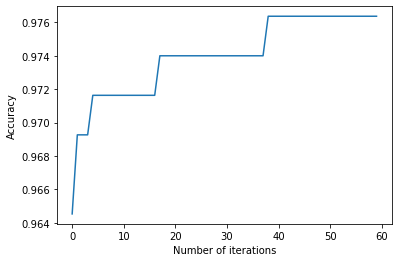

In [115]:
# ---------------------------------------------------#   
#   Select feature with Meta-heuristic algorithms   #
#--------------------------------------------------# 

##---   Define mask of feature   ---##
def mask_feature(mask):
    x_new = deepcopy(x)
    age_mean = mean(x_new['Age at Diagnosis'])
    x_new[isnan(x_new)]= age_mean
    x_new = x_new*mask
    x_new = x_new.loc[:,~(x_new==0.0).all(axis=0)]
    return x_new

##---   Define objective function   ---##
def obj_fun(mask):
    x_new = mask_feature(mask)
    clf = svm.SVC(kernel = 'rbf', gamma='auto').fit(x_new, y) # you can change classifier according to your request
    return -clf.score(x_new, y)

##---   Optimize by Genetic Algorithm   ---##
from sko.GA import GA

ga = GA(func=obj_fun, n_dim=x.shape[1], size_pop=30, max_iter=60, lb=0, ub=1, precision=1)
best_x, best_y = ga.run()

##---   Report Results   ---##
x_selected = mask_feature(best_x) # Selected feature
print('Accuracy utilizing selected feature:', -best_y)
print("Num of Selected Features: %d" % (best_x==1).sum())
print("Selected Features:", (best_x==1))

##---   Plot of evalution process for highest accuracy   ---##
Y_history = pd.DataFrame(ga.all_history_Y)
Y = [-i for i in Y_history.min(axis=1)]
plt.plot(Y)
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.show()

# ##---   Plot of evalution process for highest accuracy   ---##
# Y_history = pd.DataFrame(ga.all_history_Y)
# fig, ax = plt.subplots(2, 1)
# ax[0].plot(Y_history.index, -Y_history.values, '.', color='red')
# Y = [-i for i in Y_history.min(axis=1)]
# ax[1].plot(Y)
# plt.show()

In [110]:
print("Num of Selected Features: %d" % (best_x==1).sum())
print("Selected Features:", (best_x==1))

Num of Selected Features: 24
Selected Features: [ True  True  True  True False  True False  True False  True False False
 False  True False False  True False  True False  True  True  True  True
 False False  True False  True  True  True False False False  True  True
  True False  True False  True False False  True]


3. Embedded method

In [139]:
# -------------------------------#   
#   Select feature with LASSO   #
#------------------------------# 

##---   Define mask function of feature   ---##
def mask_feature(mask):
    x_new = deepcopy(x)
    age_mean = mean(x_new['Age at Diagnosis'])
    x_new[isnan(x_new)]= age_mean
    x_new = x_new*mask
    x_new = x_new.loc[:,~(x_new==0.0).all(axis=0)]
    return x_new

##---   Fill missing value with mean   ---##
x_new = deepcopy(x)
age_mean = mean(x_new['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean

##---   Feature selection   ---##   
clf = linear_model.Lasso(alpha=0.1).fit(x_new,y) # The number of features can be adjusted by alpha.
mask = (clf.coef_!=0)
x_selected = mask_feature(mask)

print("Num of Selected Features: ", x_selected.shape[1])
print("Selected Features:", mask)

Num of Selected Features:  13
Selected Features: [ True False  True  True False False False False False  True False  True
 False False False False  True  True False  True  True False False False
 False False False False False False False False False False  True  True
 False  True False False False  True False False]


In [142]:
# ------------------------------------#   
#   Select feature with ElasticNet   #
#-----------------------------------# 

##---   Define mask function of feature   ---##
def mask_feature(mask):
    x_new = deepcopy(x)
    age_mean = mean(x_new['Age at Diagnosis'])
    x_new[isnan(x_new)]= age_mean
    x_new = x_new*mask
    x_new = x_new.loc[:,~(x_new==0.0).all(axis=0)]
    return x_new

##---   Fill missing value with mean   ---##
x_new = deepcopy(x)
age_mean = mean(x_new['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean

##---   Feature selection   ---##   
clf = linear_model.ElasticNet(alpha=0.2, l1_ratio=0.6).fit(x_new,y) # The number of features can be adjusted by alpha and l1_ratio.
mask = (clf.coef_!=0)
x_selected = mask_feature(mask)

print("Num of Selected Features: ", x_selected.shape[1])
print("Selected Features:", mask)

Num of Selected Features:  12
Selected Features: [ True False  True  True False False False False False  True False  True
 False False False False  True  True False  True  True False False False
 False False False False False False False False False False  True  True
 False  True False False False False False False]


In [164]:
# ------------------------------------------#   
#   Select feature with Ridge Classifier   #
#-----------------------------------------# 

##---   Fill missing value with mean   ---##
x_new = deepcopy(x)
age_mean = mean(x_new['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean

##---   Feature selection   ---##   
clf = linear_model.RidgeClassifier(alpha=2) # The number of features can be adjusted by alpha.
sfm = feature_selection.SelectFromModel(clf).fit(x_new, y)
x_selected = sfm.transform(x_new)

print("Num of Selected Features: %d" % x_selected.shape[1])
print("Selected Features: %s" % sfm.get_support())

Num of Selected Features: 17
Selected Features: [ True  True False  True False  True False  True  True False False  True
 False False False  True False False False False False False  True  True
 False False False  True False False  True False False  True  True False
 False False  True  True False False False  True]


In [148]:
clf.coef_

##---   Approach 1: select k important features   ---##
# Select features according to the k highest scores.
x_selected = feature_selection.SelectFromModel(clf).fit_transform(x_new, y)
print('Number of selected features:',x_selected.shape)

# ##---   Approach 2: select a certain percentile important features   ---##
# # Select features according to a percentile of the highest scores.
# x_selected = feature_selection.SelectPercentile(clf, percentile=20).fit_transform(x_new, y)
# print('Number of selected features:',x_selected.shape)

Number of selected features: (423, 16)


## Part 4. Feature Construction

In [226]:
#---function define for Feature Construction---#
def Featureadd(x):
    #---Add by column---#
    for j in range(0,x.shape[1]-1):
        addValue = x.iloc[:,j+1:]+x.iloc[:,j].values.reshape(423,1)
        if j ==0:
            xadd = addValue
        else:
            xadd = pd.concat([xadd, addValue], axis=1)      
    xadd.columns =['add%d'%i for i in range(xadd.shape[1])]
    xadd.index = x.index
    return xadd

def Featuresub(x):
    #---Subtract by column---#
    for j in range(0,x.shape[1]-1):
        subValue = x.iloc[:,j+1:]-x.iloc[:,j].values.reshape(423,1)
        if j ==0:
            xsub = subValue
        else:
            xsub = pd.concat([xsub, subValue], axis=1)
    xsub.index = x.index
    xsub.columns =['sub%d'%i for i in range(xsub.shape[1])]
    return xsub


def Featuremul(x):
    #---Multiply by column---#
    for j in range(0,x.shape[1]-1):
        mulValue = x.iloc[:,j+1:].mul(x.iloc[:,j].values,axis=0)   
        if j ==0:
            xmul = mulValue
        else:
            xmul = pd.concat([xmul, mulValue], axis=1)
    xmul.index = x.index
    xmul.columns =['mul%d'%i for i in range(xmul.shape[1])]
    return xmul


def Featurediv(x):
    #---Divide by column---#
    for j in range(0,x.shape[1]-1):
        divValue = x.iloc[:,j+1:].div(x.iloc[:,j].values,axis=0)   
        if j ==0:
            xdiv = divValue
        else:
            xdiv = pd.concat([xdiv, divValue], axis=1)
    xdiv.index = x.index
    xdiv.columns = ['div%d'%i for i in range(xdiv.shape[1])]
    return xdiv

In [228]:
# --------------------------------#   
#      Feature consturction      #
#-------------------------------# 

##---   Fill missing value with mean   ---##
x_new = deepcopy(x)
age_mean = mean(x_new['Age at Diagnosis'])
x_new[isnan(x_new)]= age_mean

##---   Select Important Feature   ---##   
clf = linear_model.RidgeClassifier(alpha=2) # The number of features can be adjusted by alpha.
sfm = feature_selection.SelectFromModel(clf).fit(x_new, y)
x_Imp = pd.DataFrame(sfm.transform(x_new), index=x_new.index)
print("Num of Selected Features: %d" % x_Imp.shape[1])
print("Selected Features: %s" % sfm.get_support())


##------Feature Construction------##       
#---only apply on important feature---#
xadd = Featureadd(x_Imp) #--- feature construction by adding two colums one by one
xsub = Featuresub(x_Imp) #--- feature construction by subtracting two colums one by one
xmul = Featuremul(x_Imp) #--- feature construction by multiplying two colums one by one
xdiv = Featurediv(x_Imp) #--- feature construction by dividing two colums one by one
x_fc = pd.concat([x_new, xadd, xsub, xmul, xdiv], axis=1,join='outer')
x_fc

Num of Selected Features: 17
Selected Features: [ True  True False  True False  True False  True  True False False  True
 False False False  True False False False False False False  True  True
 False False False  True False False  True False False  True  True False
 False False  True  True False False False  True]


,Median cfDNA Fragment Size (bp),GC Corrected Fragment Ratio Profile*,Age at Diagnosis,PA Score,% of Mapped Reads Mapping to Mitochondria,Z Score (chr1p),Z Score (chr1q),Z Score (chr2p),Z Score (chr2q),Z Score (chr3p),...,div126,div127,div128,div129,div130,div131,div132,div133,div134,div135
Patient,,,,,,,,,,,,,,,,,,,,,
CGCRC291,163,0.526793,69.0,23.743120,0.000484,-20.271939,-18.185445,25.086292,26.201187,-102.967989,...,0.570557,0.026896,0.395535,0.581877,0.047140,0.693244,1.019840,14.705978,21.634156,1.471113
CGCRC292,166,0.883525,51.0,2.025100,0.000270,-1.360357,-1.689020,-1.415853,-1.352942,-2.309886,...,0.531418,1.068812,0.891835,0.364218,2.011247,1.678218,0.685371,0.834417,0.340769,0.408392
CGCRC293,166,0.920598,55.0,6.660453,0.000748,5.375687,5.636012,5.377756,5.555101,6.744645,...,0.815279,0.405368,0.664431,0.307246,0.497214,0.814973,0.376860,1.639080,0.757943,0.462420
CGCRC294,166,0.890421,67.0,3.581623,0.000188,-1.434739,-1.592492,-0.844961,-1.044544,-3.685217,...,0.843163,1.394395,1.104462,1.505804,1.653766,1.309902,1.785898,0.792073,1.079898,1.363383
CGCRC296,166,0.869467,76.0,2.282642,0.000369,-1.993784,-1.630529,-0.161714,-0.600607,-0.923023,...,-1.741231,-1.477969,-3.716110,-2.192444,0.848807,2.134186,1.259135,2.514336,1.483416,0.589983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGST58,169,0.909439,58.0,3.158140,0.000696,-0.728686,0.682219,-0.635536,-0.464875,-4.373167,...,-3.361505,-1.297856,-0.120737,-1.628261,0.386094,0.035918,0.484385,0.093028,1.254578,13.485983
CGST67,170,0.885311,69.0,4.740439,0.003245,0.110236,0.788661,-2.006302,0.703965,-3.931147,...,-0.299257,-0.135570,0.246540,0.013960,0.453021,-0.823843,-0.046649,-1.818552,-0.102972,0.056623
CGST77,170,0.829526,70.0,5.535665,0.001851,-2.613600,-0.651890,-0.554435,2.991711,-0.313590,...,2.515354,0.103195,2.057422,1.508033,0.041026,0.817945,0.599531,19.937269,14.613465,0.732972
